In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm

# Circular distance function
def circ_dis(phi_1, phi_2):
  dis = phi_1 - phi_2
  dis = np.where(dis > np.pi, dis - 2 * np.pi, dis)
  dis = np.where(dis < -np.pi, dis + 2 * np.pi, dis)
  return dis


In [ ]:
# Default parameters
# Grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# Cell number
num_p = int(200)
rho_p = num_p / L
rho_g = rho_p
num_g = int(rho_g * 2 * np.pi)  # Ensure the rho of both networks is equal
M = len(Lambda)
# Feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)

# Divisive normalization
k_p = 20.
k_g = Lambda / 2 / np.pi * k_p
# Time constants
tau_p = 1
tau_g = 2 * np.pi * tau_p / Lambda
# Input strength
alpha_p = 0.05
alpha_g = 0.05

noise_ratio = 0.007


Progress: 0.00%
Progress: 10.00%
Progress: 20.00%
Progress: 30.00%
Progress: 40.00%
Progress: 50.00%
Progress: 60.00%
Progress: 70.00%
Progress: 80.00%
Progress: 90.00%
0.00031853997427544467
Total runtime: 657.34 seconds


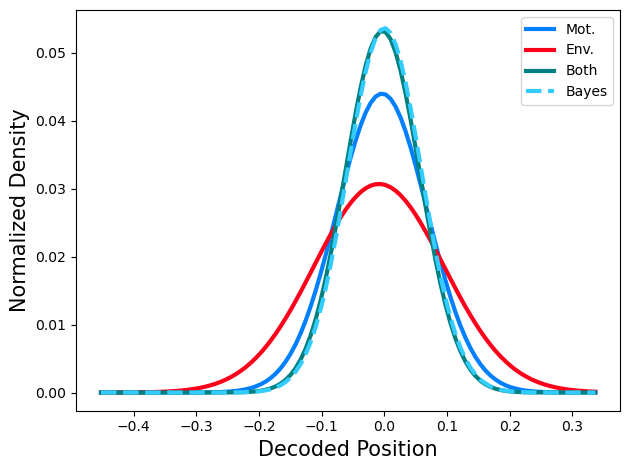

In [ ]:

def parameter_check(a_p=0.3, J_p=20, trial_num=100, plot=True, figindex = 1):
    # connection range
    # a_p = 0.3
    a_g = a_p / Lambda * 2 * np.pi
    # connection strength
    # J_p = 20
    J_g = J_p
    J_pg = J_p / 25
    P_CANN = Place_net(z_min=0, z_max=L, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p)
    # Grid cells
    G_CANNs = bm.NodeList()
    for i in range(M):
        G_CANNs.append(Grid_net(z_min=0, z_max=L, num=num_g, num_hpc=num_p, L=Lambda[i], a_g=a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))

    Coupled_model = Coupled_Net(HPC_model=P_CANN, MEC_model_list=G_CANNs, num_module=M)

    def GOP_decoding(z_t, phi_t, Ip, Ig, alpha_p_infer, alpha_g_infer, Ag, Ap, Rp, total_itenoise_rations=5000):
        sigma_g = np.sqrt(np.sqrt(np.pi) * Ag ** 3 * rho_g * tau_g / (a_g * alpha_g_infer))
        sigma_phi = np.sqrt(8 * np.pi * Ag * tau_g / (Lambda * J_pg * rho_p * Rp))
        sigma_p = np.sqrt(np.sqrt(np.pi) * Ap ** 3 * rho_p * tau_p / (a_p * alpha_p_infer))
        sigma_g_infer = sigma_g * noise_ratio
        sigma_phi_infer = sigma_phi * noise_ratio
        sigma_p_infer = sigma_p * noise_ratio
        eta = 30. * 1e-6
        z_ts = []
        phi_ts = []
        z_ts.append(z_t)
        phi_ts.append(phi_t)
        z_encode_space = np.linspace(0, L, num_p, endpoint=False)

        for itenoise_ration in range(total_itenoise_rations):
            fg_prime = np.zeros((M, num_g))
            for i in range(M):
                dis_theta = circ_dis(theta, phi_t[i])
                fg_prime[i, :] = dis_theta / (2 * a_g[i] ** 2) * np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))

            dis_z = z_encode_space - z_t
            fp_prime = dis_z / (2 * a_p ** 2) * np.exp(-dis_z ** 2 / (4 * a_p ** 2))
            
            Ig_fgprime_prod = Ig * fg_prime
            Ig_fgprime_prod = np.sum(Ig_fgprime_prod, axis=1)
            dphi_fr = Ig_fgprime_prod / sigma_g_infer ** 2

            Ip_fp_prime_prod = Ip * fp_prime
            Ip_fp_prime_prod = np.sum(Ip_fp_prime_prod)
            dr_fr = Ip_fp_prime_prod / sigma_p_infer ** 2

            phi_z = np.mod(z_t / Lambda, 1) * 2 * np.pi
            dis_phi = circ_dis(phi_z, phi_t)
            dphi_tr = 1 / sigma_phi_infer ** 2 * dis_phi
            dr_tr = np.sum(-2 * np.pi / (Lambda * sigma_phi_infer ** 2) * dis_phi)

            dphi = dphi_fr + dphi_tr
            phi_t = phi_t + eta * dphi
            
            phi_t = np.mod(phi_t, 2 * np.pi)
            
            dr = dr_fr + dr_tr
            z_t = z_t + eta * dr

            z_ts.append(z_t)
            phi_ts.append(phi_t)
        return np.array(z_ts), np.array(phi_ts)

    def Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.05, Coupled_model=Coupled_model):
        Coupled_model.reset_state()
        def initial_net(Ip, Ig): 
            Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)

        def run_net(i, Ip, Ig): 
            Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
            phi_decode = Coupled_model.phase
            z_decode = Coupled_model.HPC_model.center
            rp = Coupled_model.HPC_model.r
            up = Coupled_model.HPC_model.u
            rg = bm.zeros([M, num_g])
            ug = bm.zeros([M, num_g])
            for mi in range(M):
                rg[mi, :] = Coupled_model.MEC_model_list[mi].r
                ug[mi, :] = Coupled_model.MEC_model_list[mi].u
            return z_decode, phi_decode, rp, up, rg, ug

        T_init = 500
        z0 = z_truth
        phi_0 = phi_truth
        fg = np.zeros((M, num_g))
        for i in range(M):
            dis_theta = circ_dis(theta, phi_0[i])
            fg[i, :] = np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))
        dis_x = x - z0
        fp = np.exp(-dis_x ** 2 / (4 * a_p ** 2))
        I_place = 1 * np.repeat(fp[np.newaxis, :], T_init, axis=0)
        I_grid = 1 * np.repeat(fg[np.newaxis, :, :], T_init, axis=0)
        I_place[int(T_init / 3):, :] = 0
        I_grid[int(T_init / 3):, :, :] = 0

        bm.for_loop(initial_net, (I_place, I_grid), progress_bar=False)
        T = 5000
        indices = np.arange(T)
        I_place = alpha_p * np.repeat(Ip[np.newaxis, :], T, axis=0)
        I_grid = alpha_g * np.repeat(Ig[np.newaxis, :, :], T, axis=0)
        z_record, phi_record, rp, up, rg, ug = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)

        return z_record, phi_record, up, rp, ug, rg

    # Main simulation
    neural_noise_sigma = 0.2
    noise_level_place = 0.25
    noise_level_grid = 0.22
    # trial_num = 50
    z_truth = 30
    phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
    sigma_phi = np.array([31.7,23.8,19])*neural_noise_sigma/25
    z_decode_gop = np.zeros(trial_num)
    z_decode_net = np.zeros(trial_num)
    z_decode_net_motion = np.zeros(trial_num)
    z_decode_net_visual = np.zeros(trial_num)


    for i in range(trial_num):
        z_truth = 30
        phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
        z_e = z_truth
        psi = phi_truth + sigma_phi * np.random.randn(M)
        Ig = np.zeros((M, num_g))
        for j in range(M):
            dis_theta = circ_dis(theta, psi[j])
            Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + noise_level_grid * np.random.randn(num_g)
        dis_x = x - z_e
        Ip = np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + noise_level_place * np.random.randn(num_p) 
        z_decode_n, _, up, rp, ug, rg = Net_decoding(z_truth, phi_truth, Ip, Ig)

        max_up = np.max(up, axis=1)
        max_rp = np.max(rp, axis=1)
        Ap = np.max(max_up[-1])
        Rp = np.max(max_rp[-1])
        Ag = np.zeros(M,)
        Rg = np.zeros(M,)
        for mi in range(M):
            max_ug = np.max(ug[:, mi, :], axis=1)
            max_rg = np.max(rg[:, mi, :], axis=1)
            Ag[mi] = np.max(max_ug[-1])
            Rg[mi] = np.max(max_rg[-1])
        z_decode_g, _ = GOP_decoding(z_t=z_truth, phi_t=phi_truth, Ip=Ip, Ig=Ig, alpha_p_infer=0.05, alpha_g_infer=0.05, Ap=Ap, Rp=Rp, Ag=Ag)

        z_decode_mot, _, _, _, _, _ = Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0., alpha_g=0.05)
        z_decode_vis, _, _, _, _, _ = Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.)

        z_decode_net_motion[i] = z_decode_mot[-1]
        z_decode_net_visual[i] = z_decode_vis[-1]

        z_decode_gop[i] = z_decode_g[-1]
        z_decode_net[i] = z_decode_n[-1]
        if i % 10 == 0:
            print(f"Progress: {i/trial_num*100:.2f}%")

    z_decode_all = np.concatenate([z_decode_net, z_decode_net_motion, z_decode_net_visual, z_decode_gop])
    min_z = np.min(z_decode_all)
    max_z = np.max(z_decode_all)
    # Plot the histogram of z_decode_gop and its Gaussian fit
    xmin, xmax = min_z, max_z

    def gaussian_fit(data, xmin, xmax):
        mu, std = norm.fit(data)
        x = np.linspace(xmin-0.1, xmax+0.1, 100)
        p = norm.pdf(x, mu, std)
        return x, p

    sigma_1 = np.std(z_decode_net_motion)
    sigma_2 = np.std(z_decode_net_visual)
    sigma_bayes = np.sqrt(1/(1/sigma_1**2 + 1/sigma_2**2))
    sigma_net = np.std(z_decode_net)

    KL_div = np.log(sigma_bayes/sigma_net)+(sigma_net**2+(np.mean(z_decode_net) - np.mean(z_decode_gop))**2) / (2*sigma_bayes**2) - 1/2

    if plot == True:
        import matplotlib as mpl
        mpl.rcParams['axes.labelsize'] = 15

        x_int_gop, p_int_gop = gaussian_fit(z_decode_gop, xmin, xmax)
        x_int_net, p_int_net = gaussian_fit(z_decode_net, xmin, xmax)
        x_mot_net, p_mot_net = gaussian_fit(z_decode_net_motion, xmin, xmax)
        x_vis_net, p_vis_net = gaussian_fit(z_decode_net_visual, xmin, xmax)
        p_bayesian = np.exp(-(x_int_gop-30)**2/(2*sigma_bayes**2))
        plt.plot(x_mot_net-30, p_mot_net/np.sum(p_mot_net),linewidth=3,label='Mot.',color=[0.,0.5,1])
        plt.plot(x_vis_net-30, p_vis_net/np.sum(p_vis_net),linewidth=3,label='Env.',color=[1,0,0.1])
        plt.plot(x_int_net-30, p_int_net/np.sum(p_int_net),linewidth=3,label='Both',color=[0,0.5,0.5])
        plt.plot(x_int_gop-30, p_bayesian/np.sum(p_bayesian),linewidth=3, linestyle='--',label='Bayes',color=[0.2,0.8,1])
        plt.xlabel('Decoded Position')
        plt.ylabel('Normalized Density')
        plt.legend()
        plt.tight_layout()
        name = "example_bayes_" + str(figindex) + ".png"
        plt.savefig(name)
    return KL_div, sigma_bayes, sigma_net, np.mean(z_decode_net), np.mean(z_decode_gop)
    # p_bayesian = np.exp(-(x_int_gop-30)**2/(2*sigma_3**2))




start_time = time.time()
KL_div, sigma_bayes, sigma_net, mean_net, mean_bayes = parameter_check(a_p=0.25, J_p=20, trial_num=100, plot=True)
print(KL_div)

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

# num_exp = 6
# KL_div = np.zeros(num_exp,)
# sigma_bayes = np.zeros(num_exp,)
# sigma_net = np.zeros(num_exp,)
# mean_net = np.zeros(num_exp,)
# mean_bayes = np.zeros(num_exp,)
# J_p = np.linspace(15,25,num_exp)

# start_time = time.time()
# for i in range(num_exp):
#     KL_div[i], sigma_bayes[i], sigma_net[i], mean_net[i], mean_bayes[i] = parameter_check(a_p=0.3, J_p=J_p[i], trial_num=100, plot=False)
#     print("Trail:", i)
    # print(KL_div)

# end_time = time.time()
# print(f"Total runtime: {end_time - start_time:.2f} seconds")




In [11]:
data = np.load('data/paramter_sensitivity_Jp.npz')
KL_div=data['KL_div']
Sigmas=data['Sigmas']
Means=data['Means']
print(KL_div)

[0.00593714 0.00483675 0.00286295 0.00335388 0.00225881 0.00161569]


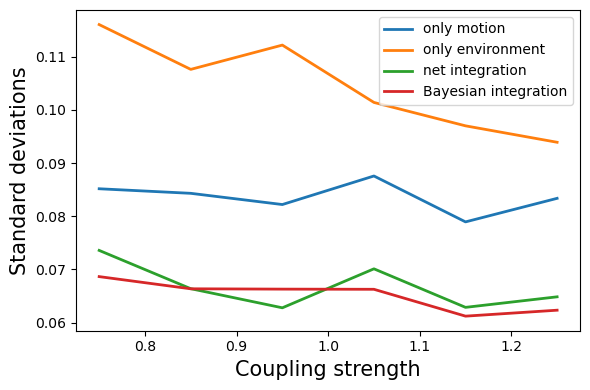

In [26]:
num_exp = 6
J_p = np.linspace(15,25,num_exp) / 20
# plt.plot(KL_div)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.figure(figsize=(6,4))
for i in range(4):
    plt.plot(J_p, Sigmas[:,i], color=colors[i], linewidth=2)
plt.legend(['only motion','only environment','net integration','Bayesian integration'])
plt.xlabel('Coupling strength')
plt.ylabel('Standard deviations')
plt.tight_layout()
plt.savefig('figures_example/standard_deviations.png')